In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [ ]:
diamonds_df = pd.read_csv('diamonds.csv')

In [ ]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


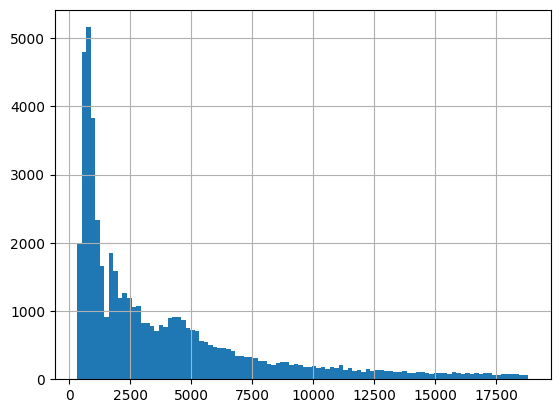

In [ ]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [ ]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [ ]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [ ]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [ ]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

In [ ]:
X_train.shape

(37758, 9)

# Обучаем модель линейной регрессии

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
score = r2_score(y_pred, y_test)

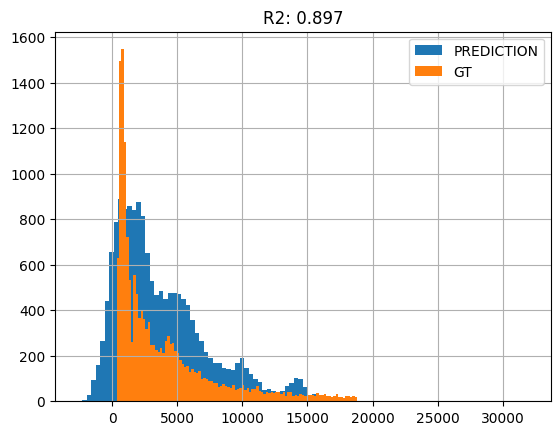

In [ ]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [ ]:
class MLPRegressor():
    def __init__(self, lr=1e-3,size_layers=[9,100,100,1], epochs=3000):
        self.lr= lr
        self.epochs= epochs
        self.layers=size_layers
        self.weights = []
        self.biases  = []
        self.losses  = []

    def __del__(self):
        del self.lr
        del self.epochs
        del self.layers
        del self.weights
        del self.biases
        del self.losses

    def loss(self, y_true, y_pred):
        return (1/y_true.shape[1])*((y_true - y_pred)**2)

    def derivative_loss(self, y_true, y_pred):
        return -(1/y_true.shape[1])*2*(y_true - y_pred)

    def sigmoid(self, z):
        return 1/(1+np.exp(-z))

    def derivative_sigmoid(self, z):
        return self.sigmoid(z)*(1 - self.sigmoid(z))

    def linear(self, z: np.array):
        return z

    def derivative_linear(self, z):
        der=np.zeros(z.shape)
        der[0, :] = 1
        return der

    def forward_pass(self, X):
        input_to_layer = np.copy(X)
        activations    = [input_to_layer]
        derivatives    = [np.zeros(X.shape)]

        for i in range(len(self.layers)-1):
          if(i<=len(self.layers)-3):
            z_i = np.matmul(self.weights[i],input_to_layer) + self.biases[i]
            input_to_layer = self.sigmoid(z_i)
            activations.append(input_to_layer)
            derivatives.append(self.derivative_sigmoid(z_i))
          else:
            z_i = np.matmul(self.weights[i],input_to_layer) + self.biases[i]
            input_to_layer = self.linear(z_i)
            activations.append(input_to_layer)
            derivatives.append(self.derivative_linear(z_i))

        return activations, derivatives

    def backward_pass(self,activations,derivatives,y):
        self.losses.append(np.sum(self.loss(y, activations[-1])))
        print("loss ",np.sum(self.loss(y, activations[-1]))/10000)
        dz=[]
        dy=[]
        dw=[]
        db=[]
        dy.append(self.derivative_loss(y, activations[-1]))
        dz.append(np.multiply(dy[-1], derivatives[-1]))
        dw.append(np.matmul(dz[-1], activations[-2].T))
        db.append(np.sum(dz[-1], axis=1))

        for i in range(len(self.weights)-2,-1,-1):
            dy.append(np.matmul(self.weights[i+1].reshape(-1,np.array(dz[-1].shape[0])), dz[-1]))
            dz.append(np.multiply(dy[-1], derivatives[i+1]))
            dw.append(np.matmul(dz[-1], activations[i].T))
            db.append(np.sum(dz[-1], axis=1))
        return  dw[::-1], db[::-1]

    def update_weights(self, dl_dw, dl_db) :
        for i in range(len(self.layers)-1):
          self.weights[i] -= self.lr*dl_dw[i]
          self.biases[i]  -= self.lr*dl_db[i].reshape(-1,1)

    def fit(self, X, y):
        self.weights.clear()
        self.biases.clear()
        self.losses.clear()
        for idx in range(len(self.layers)-1):
            self.weights.append(np.random.randn(self.layers[idx+1], self.layers[idx]))
            self.biases.append(np.random.randn(self.layers[idx+1], 1))

        for j in range(self.epochs):
            if(j==1000):
              self.lr/=2
            activations, derivatives = self.forward_pass(X.T)
            dw, db = self.backward_pass(activations, derivatives, y.T)
            self._update_weights(dw, db)

    def predict(self, X):
        input_to_layer = np.copy(X)
        for i in range(len(self.layers)-1):
          if(i<=len(self.layers)-3):
            z_i = np.matmul(self.weights[i],input_to_layer) + self.biases[i]
            input_to_layer = self.sigmoid(z_i)
          else:
            z_i = np.matmul(self.weights[i],input_to_layer) + self.biases[i]
            input_to_layer = self.linear(z_i)

        return input_to_layer[0]



# Проверяем модель MLP на выборке Diamonds

In [ ]:
from sklearn.metrics import mean_squared_error
mod= MLPRegressor(size_layers=[9,100,1])
mod.fit(X_train,y_train)
y_pred_train = mod.predict(X_train.T)
y_pred = mod.predict(X_test.T)
print(mean_squared_error(y_pred_train,y_train))
print(mean_squared_error(y_pred,y_test))

loss  3156.818526801875
loss  2956.657585001457
loss  2658.5539383553646
loss  2376.940354262263
loss  2151.5339024867467
loss  1982.5031172185936
loss  1860.9202416228454
loss  1775.960846815644
loss  1716.723438694229
loss  1675.9855238114233
loss  1648.3537933583514
loss  1629.5978483544113
loss  1616.597307868873
loss  1607.0641649877184
loss  1600.745043661558
loss  1599.2878775318184
loss  1599.3272059491835
loss  1589.518534639971
loss  1596.5694923687552
loss  1591.3728308089912
loss  1594.3750214157742
loss  1582.7554288256922
loss  1592.231169427966
loss  1587.4485471379328
loss  1584.7880845086104
loss  1579.0004817209676
loss  1586.2082097206398
loss  1587.5524189039825
loss  1586.8735407652925
loss  1587.8374722336291
loss  1579.585970699326
loss  1578.9196078608206
loss  1585.2947823525406
loss  1585.8109190445023
loss  1581.524255711122
loss  1579.3500556262966
loss  1582.4805279233701
loss  1579.9361487002552
loss  1579.1190143600627
loss  1583.970970646288
loss  1578.7

In [ ]:
print(r2_score(y_pred, y_test))

0.9439516274430022
